In [44]:
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import prep
from neuralprophet import NeuralProphet
from sklearn.metrics import mean_squared_error
#from statsmodels.tsa.seasonal import seasonal_decompose
from math import sqrt
#from sklearn.metrics import mean_squared_error
import PyPDF2

# Supress Warnings
import warnings
warnings.filterwarnings("ignore")

In [45]:
#Bring in US Vehicle Sales by year in Thousands
us_veh_sales = pd.read_csv('new_car_sales.csv')

To see the work used to clean this dataframe...please see jarads_workbook.ipynb in the Github Repo
To clean we had to transpose the table to turn columns into rows. 
Drop and rename columns to get the desired layout
Change year into datetime, remove string letters from numerical columns, and change the total_production column to int format

Take aways:
- No null values 
- Yearly data starts at 1990 before that was only measured every 5 years. 

In [46]:
us_veh_sales = us_veh_sales.rename(columns={'total_production': 'total_sale'})

In [47]:
#us_veh_sales.drop(columns='Unnamed: 0', inplace=True)

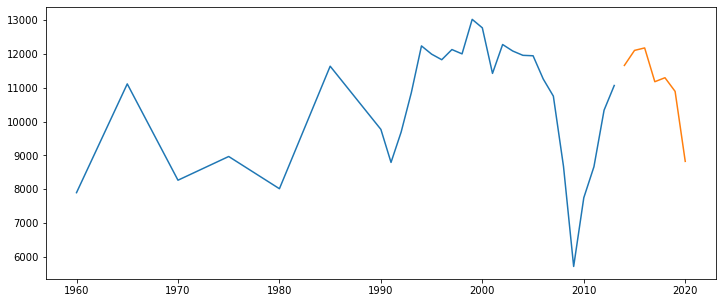

In [48]:
us_veh_train, us_veh_test = prep.train_test_only(us_veh_sales)

<AxesSubplot:ylabel='Frequency'>

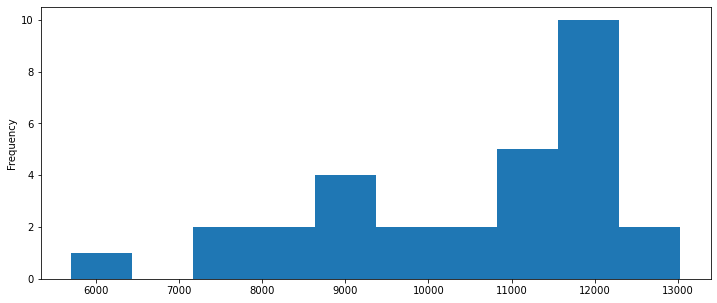

In [49]:
y = us_veh_train.total_sale
y.plot.hist()


There appears to be a normal distribution from 7k to 11k. The bulk of sales at from 11k-12k.

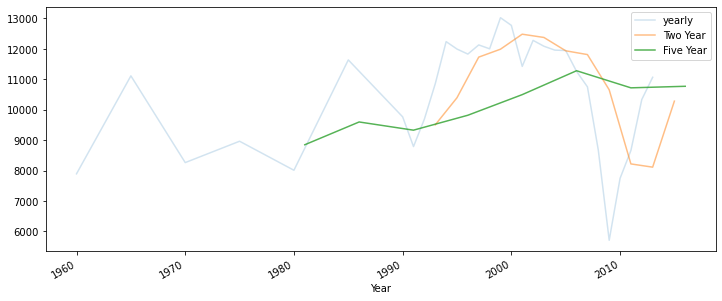

In [50]:
# Plotting different rolling averages. Specifically the 2 and 5 year
y.plot(alpha=.2, label='yearly')
y.resample('2Y').mean().rolling(2).mean().plot(alpha=.5, label='Two Year')
y.resample('5Y').mean().rolling(5).mean().plot(alpha=.8, label='Five Year')

plt.legend()

The five year trend appears to be trending higher. The two year average does not eliminate enough noise to make a difference. We lack observations to futher resample and assess trends of seasonality. 

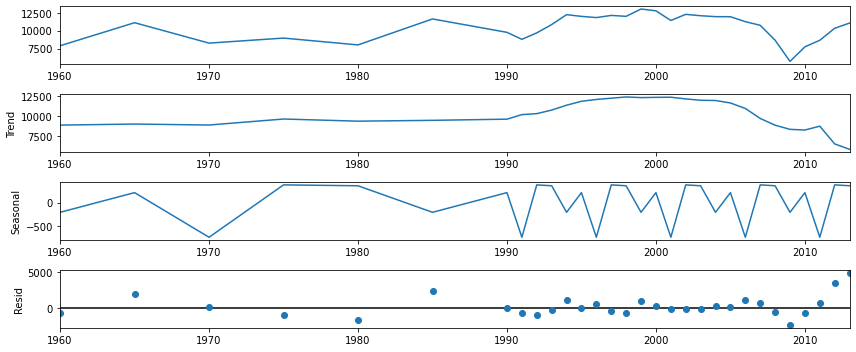

In [51]:
prep.seasonality_plots(us_veh_train, 5)

We are seeing seasonality after the 1990 data when yearly data starts being regular. The residual does goes off to 5000 towards the end of the dataset

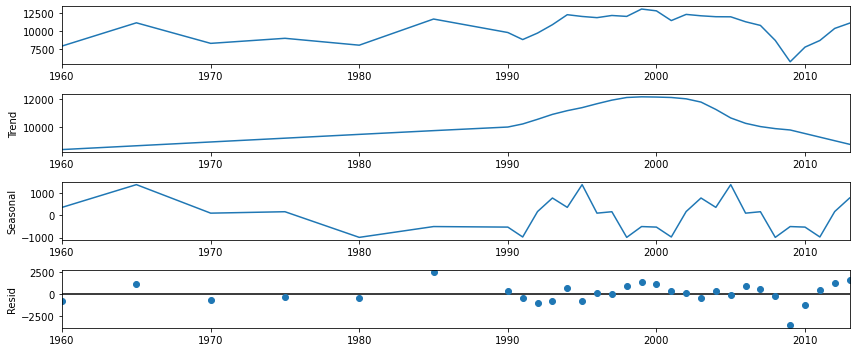

In [52]:
prep.seasonality_plots(us_veh_train, 10)

We are seeing seasonality after the 1990 data when yearly data starts being regular. The residual looks better than the 5 year seasonality. 

Overall we lack sufficient data to really determine seasonality and could just be a result of noise

## Modeling

For more models please see jarad_model_notebook.ipynb and jarad_prophet_model.ipynb

Base on modeling done in other notebooks we will use Last Observed Value


The last sale observation is: 11067
The RMSE is: 1056.0


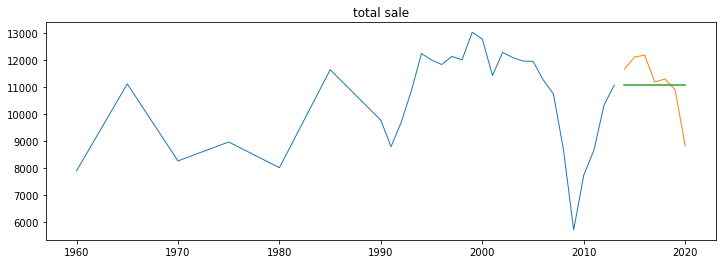

In [53]:
prep.last_obvs(us_veh_train, us_veh_test)

Using Holt Winters Exponential Smoothing Model as final model on test

In [54]:
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

The RMSE for the model is: 1599.0


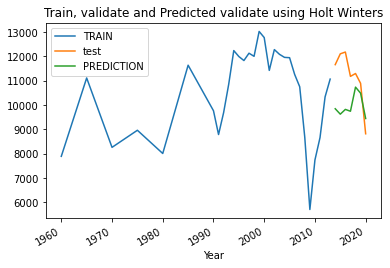

In [55]:
prep.us_car_model(us_veh_train, us_veh_test)

### The model does not beat baseline based of RMSE. The arbitrary way the data was split caused the last known observed value to have a lower RMSE than our model. We decided to use holt exponential smoothing model becuase it captures more of the movement within the dataset. We believe that this offers a more realistic and overall better fit to the data


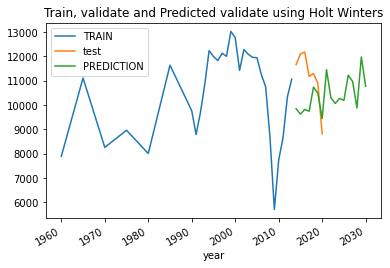

In [56]:
prep.car_forecast(us_veh_train,us_veh_test, 17)

We predicted out of the model from 2015 onward. The predictions did not capture all of 2020 decline but handled it fairly well, we are pleased with the result. 

# Moving onto US Mine Production
---
To see how we extracted and cleaned this data, please look at kevin_prep_and_explore.ipynb in the Github repo

In [57]:
us_copper = pd.read_csv('copper.csv')

In [58]:
us_copper = prep.prep_us_copper(us_copper)

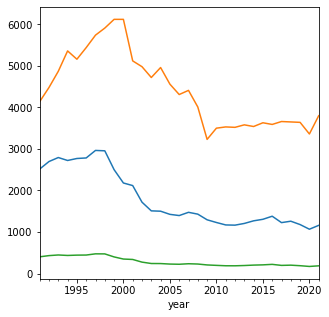

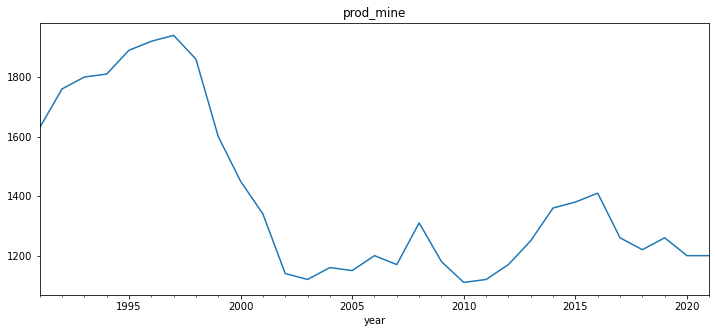

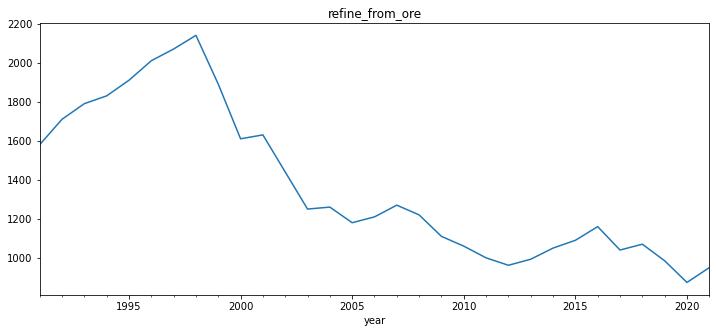

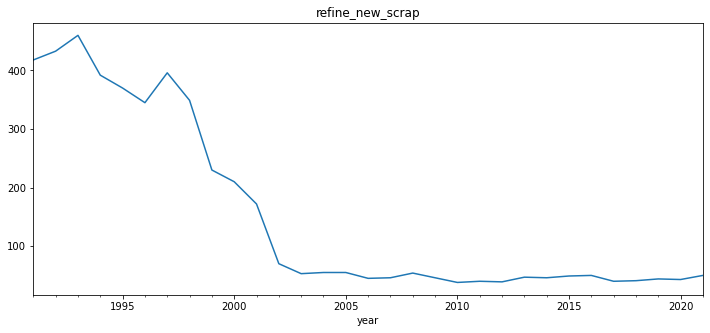

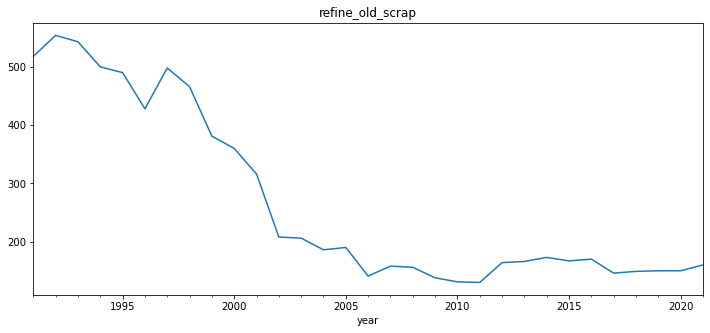

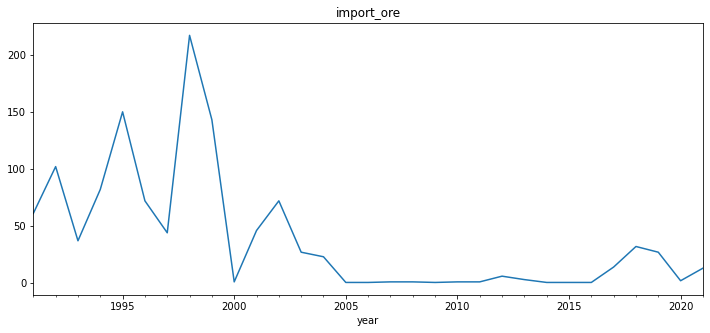

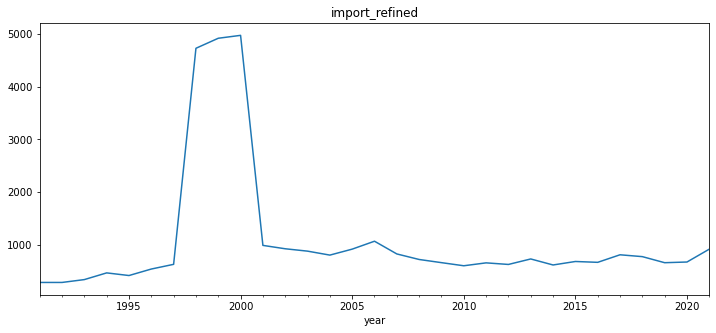

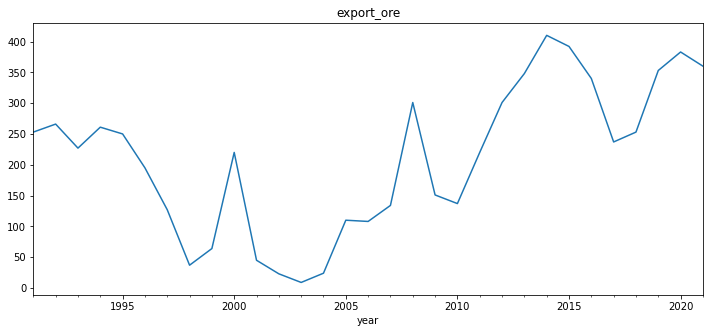

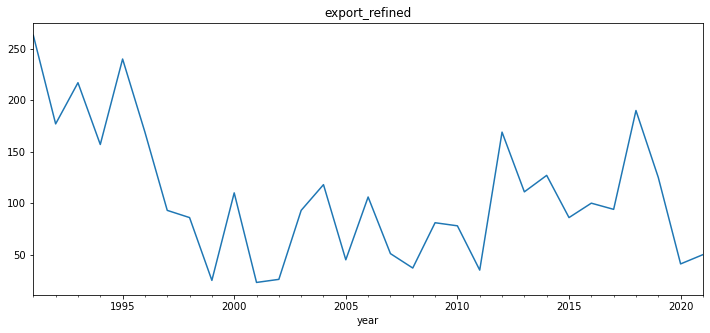

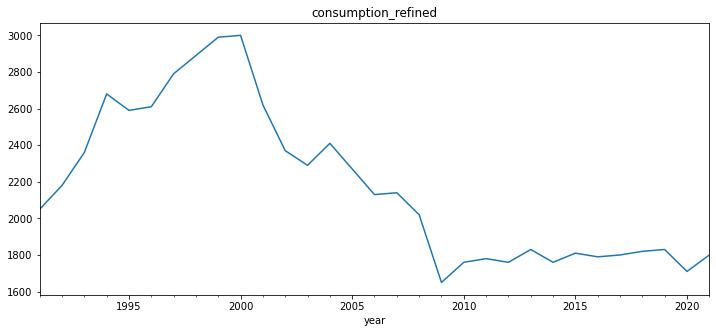

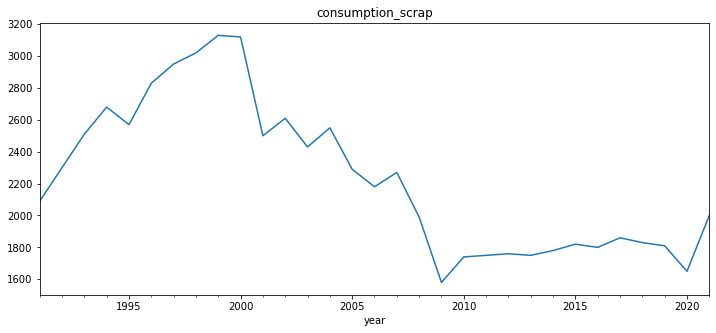

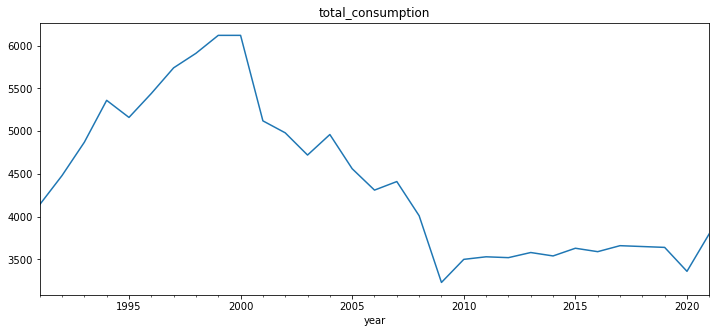

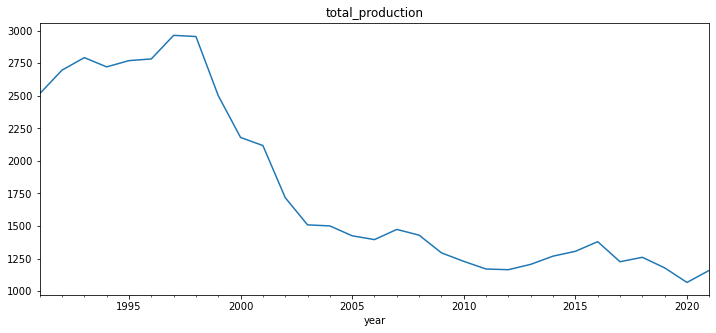

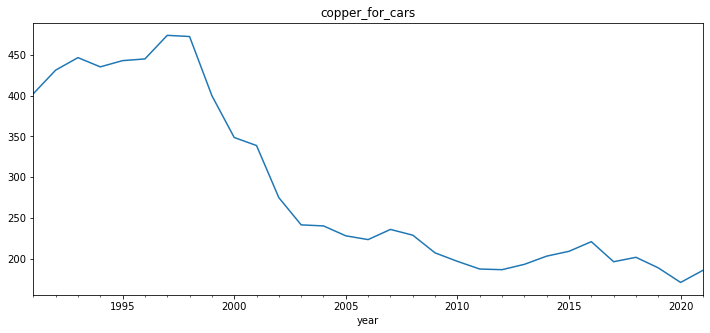

In [59]:
prep.plot_us_cop(us_copper)

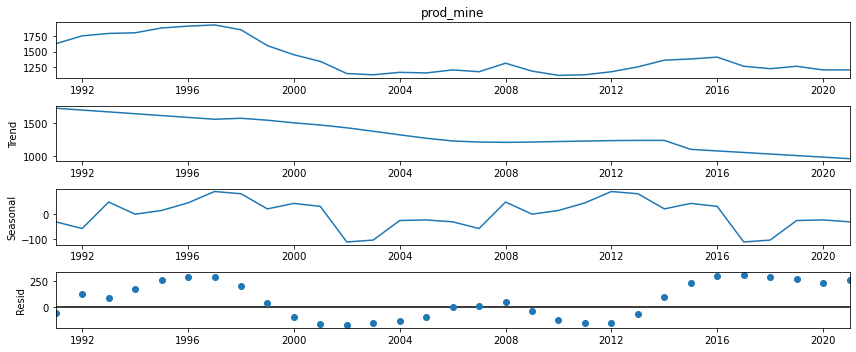

In [60]:
prep.seasonality_plots(us_copper.prod_mine, 15)

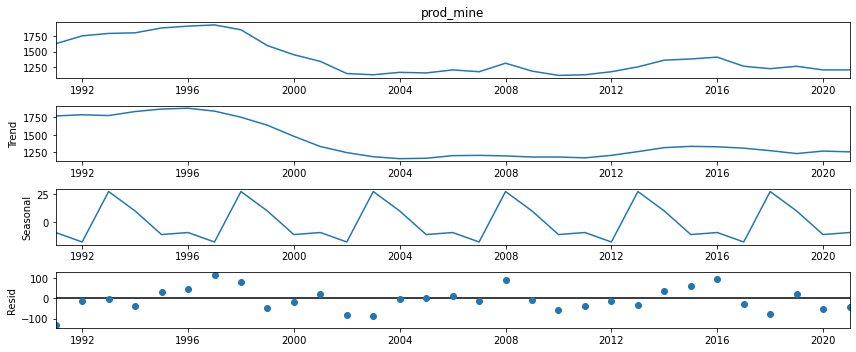

In [61]:
prep.seasonality_plots(us_copper.prod_mine, 5)

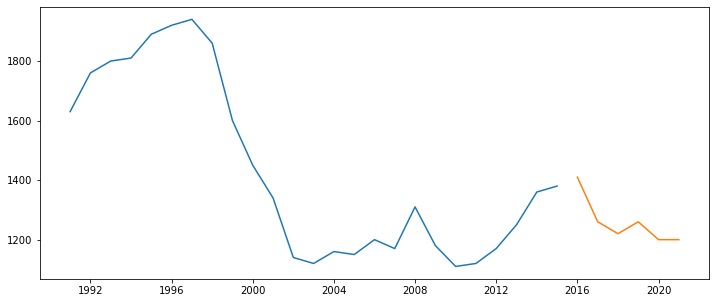

In [62]:
us_cop_train, us_cop_test = prep.train_test_us_copper(us_copper)

In [63]:
# creating data frames for modeling
us_copper = us_copper.reset_index()
us_cop_train = us_cop_train.reset_index()
us_cop_test = us_cop_test.reset_index()
production = us_copper.rename(columns={'year':'ds','total_production':'y'})[['ds', 'y']]
prod_train = us_cop_train.rename(columns={'year':'ds','total_production':'y'})[['ds', 'y']]
prod_test = us_cop_test.rename(columns={'year':'ds','total_production':'y'})[['ds', 'y']]




In [64]:
m = NeuralProphet()
m.fit(prod_train)
future = m.make_future_dataframe(production, periods=0, n_historic_predictions=True)
prod_forecast = m.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency YS corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as YS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 1000


  0%|          | 0/102 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.93E-01, min: 4.11E-02


  0%|          | 0/102 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.82E-01, min: 4.11E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.67E-01
Epoch[1000/1000]: 100%|█| 1000/1000 [00:03<00:00, 280.97it/s, SmoothL1Loss=0.000
WARNING - (NP.forecaster._make_future_dataframe) - Not extending df into future as no periods specified.You can call predict directly instead.
INFO - (NP.df_utils._infer_frequency) - Major frequency YS corresponds to 96.774% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - YS
INFO - (NP.df_utils._infer_frequency) - Major frequency YS corresponds to 96.774% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - YS
INFO - (NP.df_utils._infer_frequency) - Major frequency YS corresponds to 96.774% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - YS


<AxesSubplot:xlabel='ds'>

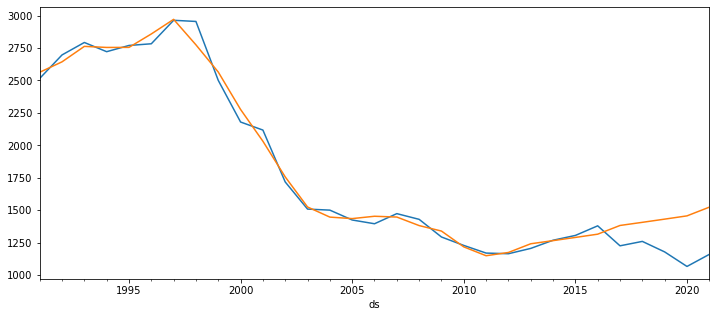

In [65]:
prod_forecast.set_index('ds').y.plot()
prod_forecast.set_index('ds').yhat1.plot()


In [66]:
prod_forecast['baseline'] = prod_forecast.y.agg('median')
MSE = mean_squared_error(prod_forecast.y, prod_forecast.baseline)
 
RMSE = sqrt(MSE)
print("Basline Root Mean Square Error:\n")
print(RMSE)

MSE = mean_squared_error(prod_forecast.y, prod_forecast.yhat1)
 
RMSE = sqrt(MSE)
print("Modeled Root Mean Square Error:\n")
print(RMSE)

Basline Root Mean Square Error:

751.8968915242774
Modeled Root Mean Square Error:

124.4627726277216


Although our Neural Prohpet did not do as well as we had hoped on the test data, it still performed 6 times better than baseline. Our next step will be to move forward with the model and project out to 2030

In [67]:
m = NeuralProphet()
m.fit(prod_train)
future = m.make_future_dataframe(production, periods=9, n_historic_predictions=True)
prod_forecast = m.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency YS corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as YS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 1000


  0%|          | 0/102 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.35E-02, min: 1.34E+00


  0%|          | 0/102 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.35E-02, min: 1.34E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.82E-02
Epoch[1000/1000]: 100%|█| 1000/1000 [00:03<00:00, 277.11it/s, SmoothL1Loss=0.001
INFO - (NP.df_utils._infer_frequency) - Major frequency YS corresponds to 96.774% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - YS
INFO - (NP.df_utils._infer_frequency) - Major frequency YS corresponds to 97.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - YS
INFO - (NP.df_utils._infer_frequency) - Major frequency YS corresponds to 97.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - YS


<AxesSubplot:xlabel='ds'>

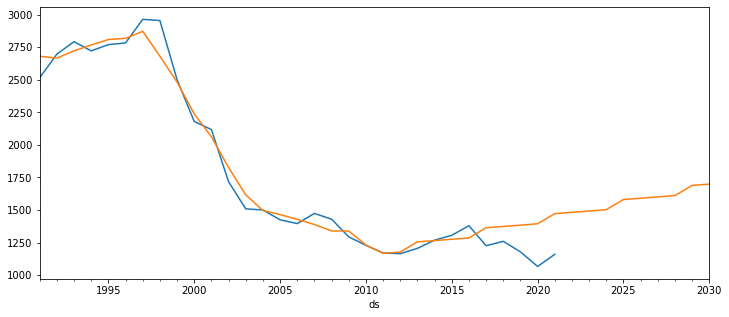

In [68]:
prod_forecast.set_index('ds').y.plot()
prod_forecast.set_index('ds').yhat1.plot()

# Moving onto Global Mine Production
---
To see the initial cleaning of this CSV please look at jeremy_capstone_working_notebook.ipynb 

In [69]:
#Bringing in global production and consumption
global_production = pd.read_csv('copper_production.csv')

In [70]:
global_production = prep.clean_copper(global_production)

In [71]:
global_production.isnull().sum()

year                  0
mine_production       0
refined_production    0
refined_usage         0
dtype: int64

In [72]:
global_production.year = pd.to_datetime(global_production.year)



In [73]:
globe_train, globe_validate, globe_test = prep.copper_split(global_production)

In [74]:

globe_train = globe_train.set_index('year')
globe_validate = globe_validate.set_index('year')
globe_test = globe_test.set_index('year')

<AxesSubplot:xlabel='year'>

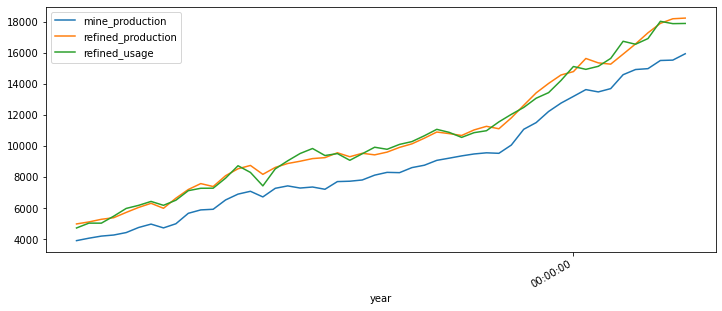

In [75]:
globe_train.plot()

<AxesSubplot:ylabel='Frequency'>

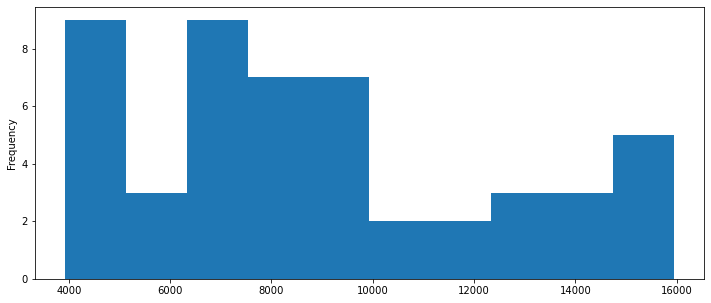

In [76]:
y = globe_train.mine_production
y.plot.hist()

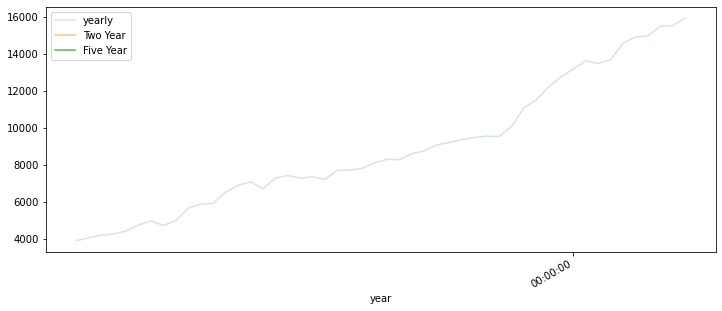

In [77]:
# Plotting different rolling averages. Specifically the 2 and 5 year
y.plot(alpha=.2, label='yearly')
y.resample('2Y').mean().rolling(2).mean().plot(alpha=.5, label='Two Year')
y.resample('5Y').mean().rolling(5).mean().plot(alpha=.8, label='Five Year')

plt.legend()

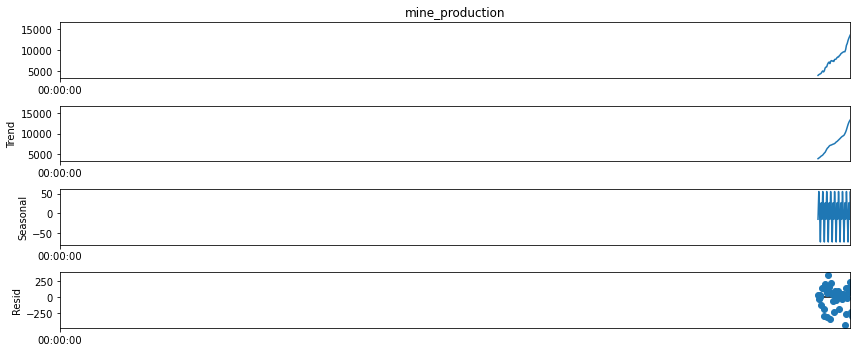

In [78]:
prep.seasonality_plots(globe_train.mine_production, 5)

The mine production RMSE is: 1533.0
The refined production RMSE is: 2544.0


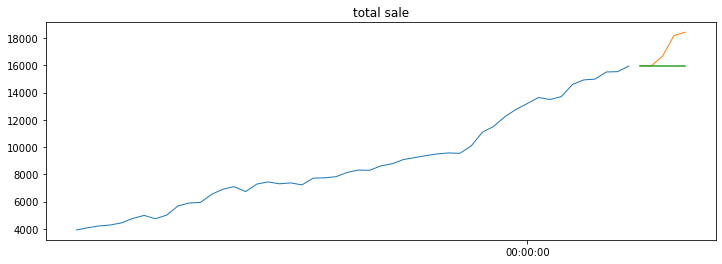

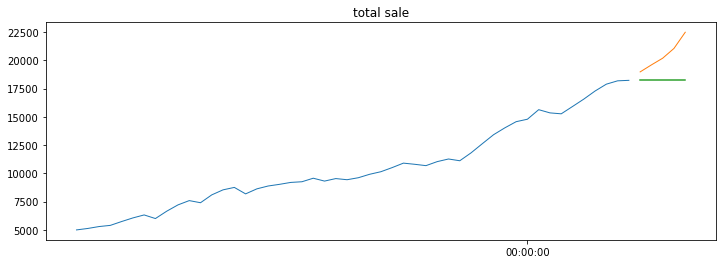

In [79]:
prep.last_global(globe_train, globe_validate)

INFO - (NP.df_utils._infer_frequency) - Major frequency N corresponds to 98.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as N
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 868
Epoch[868/868]: 100%|█| 868/868 [00:04<00:00, 203.94it/s, SmoothL1Loss=0.000148,
INFO - (NP.df_utils._infer_frequency) - Major frequency N corresponds to 98.0% of the

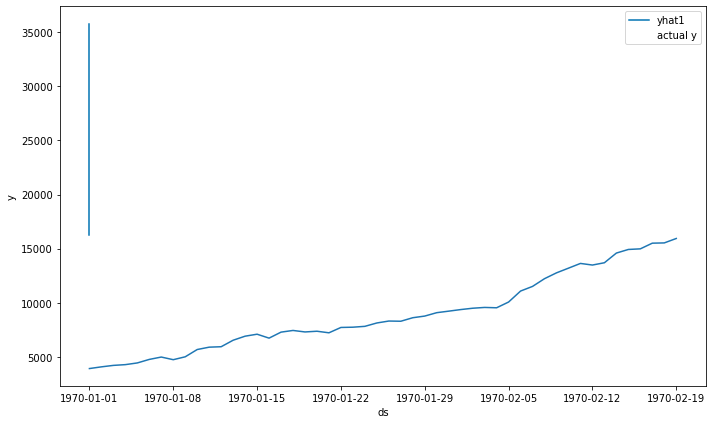

In [80]:
prep.global_prophet(globe_train, globe_validate)

# NLP sentiment analysis of Scientific Papers, News Articles, and our White Paper

## Scientific Papers:

In [81]:
science_analysis=prep.science_analysis()
science_analysis

## News Articles:

- News articles were collected off the web from 9 seperate locations

- We used scrapy to create a web spyder to crawl these websites

- To clean we used regex to remove unneccesary characters, tokenized, andd lemmatized the text, and then exported to a clean csv

In [82]:
news = pd.read_csv('clean_news.csv')
news.polarity.mean()

0.07235742112825444

### News article sentiment is ranked at: +7.2%

## White Paper:

In [86]:
white_paper_analysis = prep.white_paper_analysis()
white_paper_analysis.polarity

0    0.103154
Name: polarity, dtype: float64

# Takeaways 

- The US lacks sufficient production
- Pay more per pound for imports
- Increase Global Prod. ~1.5% w/ no other demand
- Increased recycling can help make up deficits 

# Summary

- 5,033,500 cars to be electrified
- Deficit of 312k Metric Tons
- Imports included in US Production
- Models do not account for the increase in copper for other industries
- CO2 savings make up for the increased emissions of mining